## 1) Importación de librerías necesarias

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

## 2) Funciones que se van a usar

In [4]:
"""
Given the main directory of the location of the images, the URL of each image is loaded to a dataframe with his clasification
"""
def loadData(path_main_directory):
    paths_list = list()
    label_list = list()

    for subdirectory in os.listdir(path_main_directory):
        #Build the path of every subdirectory of the main_directory
        path_subdirectory = os.path.join(path_main_directory, subdirectory)

        #Iterate over all the images of the subdirectory adding the path to the dictionary
        for image_name in os.listdir(path_subdirectory):
            image_path = os.path.join(path_subdirectory, image_name)
            paths_list.append(image_path)
            label_list.append(subdirectory)

        init_data_dict = {'path' : paths_list, 'label' : label_list}

    return pd.DataFrame(init_data_dict)

In [5]:
"""
Given the URL of the images as a list, the information of the size of the images is returned as a dataframe
"""
def getImageSizeInfo(images_path_L):
    #list of the size of each image
    images_size_L = list()
    #List of the width of each image
    images_width_L = list()
    #List of the height of each image
    images_height_L = list()
    #List of the ratio of the size of each image
    images_ratio_L = list()

    for path in images_path_L:
        image = Image.open(path)
        #Get the size of an image (given as a tuple) and append it to the list
        images_size_L.append(image.size)
        #Get the size of the image and append it to the list
        images_width_L.append(image.size[0])
        #Get the height of the image and append it to the list
        images_height_L.append(image.size[1])
        #Get the ratio (width/height) of the image and append it to the list
        images_ratio_L.append(round(image.size[0] / image.size[1], 2))

    #Dictionary with all the information
    image_info_D = {'path' : images_path_L, 'size' : images_size_L, 'width' : images_width_L, 'height' : images_height_L,'ratio' : images_ratio_L}
    #Data frame with all the information
    return pd.DataFrame(image_info_D)

In [6]:
def loadImages(tams_L, images_path_L, images_class_L):
    images_BW_D = dict()

    for i in range(0, len(tams_L)):
        #List of the representation of the images in black and white as a list
        imgs_BW_L = list()
        #List of the class of each image
        class_BW_L = list()

        for j in range(0, len(images_path_L)):
            #Open image and resize it
            img = Image.open(images_path_L[j]).resize(tams_L[i])
            #Image as a list
            arr = np.asarray(img, dtype = np.int_)
            
            imgs_BW_L.append(arr)
            class_BW_L.append(images_class_L[j])

        images_BW_D[i] = (imgs_BW_L, class_BW_L)
    
    return images_BW_D

In [7]:
"""
Given the name of the class, returns the associated numeric class
"""
def class_to_numeric(class_list):
    l = list()
    for i in range (0, len(class_list)):
        if(class_list[i] == 'angry'):
            l.append(0)
        elif(class_list[i] == 'happy'):
            l.append(1)
        elif(class_list[i] == 'sad'):
            l.append(2)
    return np.array(l)

In [8]:
def numeric_to_class(type):
    if(type == 0):
        return 'angry'
    elif(type == 1):
        return 'happy'
    else:
        return 'sad'

In [9]:
def decode(class_list):
    if(class_list[0] == 1):
        return 'angry'
    elif(class_list[1] == 1):
        return 'happy'
    else:
        return 'sad'

In [10]:
def createModel(input_shape, pool_size, kernel_size, activation_function):
    inputs = Input(shape=(input_shape), dtype=tf.float64)
    x = Conv2D(64, kernel_size, padding='same', activation=activation_function)(inputs)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, kernel_size, padding='same', activation=activation_function)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation=activation_function)(x)
    x = Dropout(.5)(x)
    logits = Dense(3, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])
    return model

## 2) Carga del conjunto de datos

Se van a cargar las URL de las imágenes en un dataframe junto a su clasificación.

El directorio principal está divido en 3 subdirectorios titulados: angry, happy y sad. Por lo que todas las URLs (imágenes) de un directorio tendrán esa clasificación.

In [11]:
#Main directory of the data
path_main_directory = './fer3'

#Load the data
init_data_df = loadData(path_main_directory)

display(init_data_df.head())
display(init_data_df.tail())

,path,label
0,./fer3\angry\PrivateTest_10131363.jpg,angry
1,./fer3\angry\PrivateTest_10304478.jpg,angry
2,./fer3\angry\PrivateTest_1054527.jpg,angry
3,./fer3\angry\PrivateTest_10590091.jpg,angry
4,./fer3\angry\PrivateTest_1109992.jpg,angry


,path,label
20014,./fer3\sad\Training_99922913.jpg,sad
20015,./fer3\sad\Training_99943858.jpg,sad
20016,./fer3\sad\Training_99950687.jpg,sad
20017,./fer3\sad\Training_99987906.jpg,sad
20018,./fer3\sad\Training_99996831.jpg,sad


Se calculan el número de ejemplos de cada clase

In [12]:
init_data_df['label'].value_counts()

label
happy    8989
sad      6077
angry    4953
Name: count, dtype: int64

Y se calcula la frecuencia de cada clase

In [13]:
init_data_df['label'].value_counts() / init_data_df['label'].count() * 100

label
happy    44.902343
sad      30.356162
angry    24.741496
Name: count, dtype: float64

Como se puede ver, la cantidad de datos de cada clase es muy similar, lo cual es una ventaja para entrenar el modelo.

## 3) Adaptación del formato de las imágenes

### Elección del tamaño:

  La elección del tamaño es muy importante, ya que tendrá efecto en el tiempo de entrenamiento del modelo y en la precisión del mismo. Aunque el tamaño de las imágenes del conjunto de datos elegido sea (48x48), se explorarán otros tamaños para evaluar los modelos con distintas características.

Se saca la información del tamaño de las imágenes y se guarda en un data frame

In [14]:
image_info_DF = getImageSizeInfo(init_data_df['path'].values)
display(image_info_DF.head())

,path,size,width,height,ratio
0,./fer3\angry\PrivateTest_10131363.jpg,"(48, 48)",48,48,1.0
1,./fer3\angry\PrivateTest_10304478.jpg,"(48, 48)",48,48,1.0
2,./fer3\angry\PrivateTest_1054527.jpg,"(48, 48)",48,48,1.0
3,./fer3\angry\PrivateTest_10590091.jpg,"(48, 48)",48,48,1.0
4,./fer3\angry\PrivateTest_1109992.jpg,"(48, 48)",48,48,1.0


Se van a probar con distintos tamaños (todos ellos dependiendientes de la anchura y altura original)

In [15]:
tams_L = list()
tams_L.append((96, 96)) #original size *2
tams_L.append((48, 48)) #original size
tams_L.append((24, 24)) #original size /2
print(tams_L)

[(96, 96), (48, 48), (24, 24)]


# Pruebas nuevas tamaños

Se van a generar varios conjuntos de datos: cada uno de ellos contendrá las imágenes en blanco y negro con distintos tamaños.

In [16]:
load_images  = loadImages(tams_L, init_data_df['path'].values, init_data_df['label'].values)

Se ve la forma de cada uno de los conjuntos de datos

In [17]:
for i in range(0, len(tams_L)):
    print(np.array(load_images[i][0]).shape)
    print(np.array(load_images[i][1]).shape)

(20019, 96, 96)
(20019,)
(20019, 48, 48)
(20019,)
(20019, 24, 24)
(20019,)


Se visualiza una imagen de prueba para ver los cambios realizados tras redimensionar

Clase:  angry


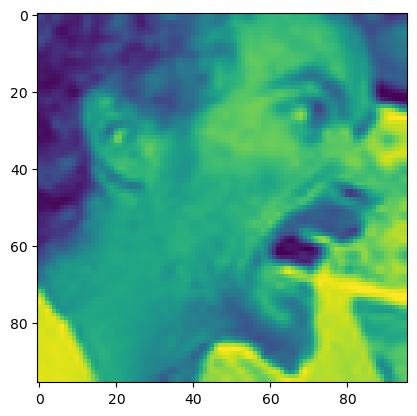

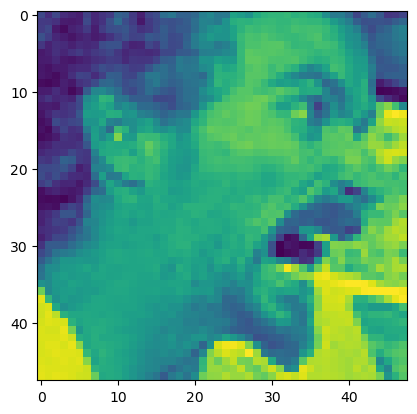

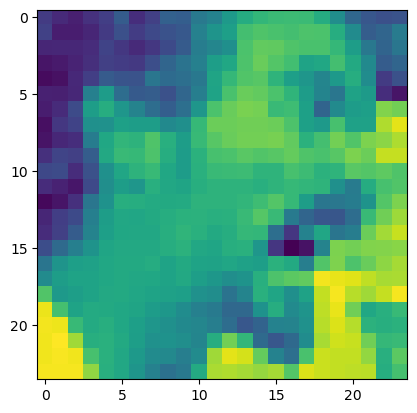

In [18]:
print("Clase: ", load_images[0][1][1])
for i in range (0, len(tams_L)):
    image = load_images[i][0][1]
    plt.imshow(image)
    plt.show()

In [19]:
#Dictionary with the train test splits for all the representations
load_train_test = dict()
for i in range(0, len(tams_L)):
    X_train, X_test, y_train, y_test = train_test_split(load_images[i][0], load_images[i][1], test_size=0.2,shuffle=True)
    load_train_test[i] = (np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test))
    print('X_train shape:', np.array(X_train).shape, 'y_train shape:', np.array(y_train).shape, 'X_test shape:', np.array(X_test).shape, 'y_test shape:', np.array(y_test).shape)

X_train shape: (16015, 96, 96) y_train shape: (16015,) X_test shape: (4004, 96, 96) y_test shape: (4004,)
X_train shape: (16015, 48, 48) y_train shape: (16015,) X_test shape: (4004, 48, 48) y_test shape: (4004,)
X_train shape: (16015, 24, 24) y_train shape: (16015,) X_test shape: (4004, 24, 24) y_test shape: (4004,)


In [20]:
#create a model for each image size, activation function, kernel size and pooling size
activations_functions = ['relu', 'sigmoid']
kernel_sizes = [2,6]
pooling_sizes = [2,3]

modelsTams = dict()
for i in range(0, len(tams_L)):
    models = dict()
    j=0
    for pool_size in pooling_sizes:
        for kernel_size in kernel_sizes:
            for activation_function in activations_functions:
                #size of the input images
                l = list(tams_L[i]) #original size
                l[0], l[1] = l[1], l[0] #transpose
                l.append(1) #include last channel
                model = createModel(l, pool_size, kernel_size, activation_function);
                models[j] = model
                j += 1
    modelsTams[i] = models

In [21]:
#print the summary of each model
for i in range(0, len(tams_L)):
    for j in range (0, len(modelsTams[i])):
        modelsTams[i][j].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                        

In [22]:
#data conditioning for each model
train_test_conditioned = dict()

for i in range(0, len(tams_L)):
    X_train = load_train_test[i][0]
    X_train = X_train.astype('float32') / 255
    
    X_test = load_train_test[i][1]
    X_test = X_test.astype('float32') / 255
    
    y_train = load_train_test[i][2]
    y_train = class_to_numeric(y_train) # Converts the string class to numeric class
    y_train = to_categorical(y_train) # Converts the classes into one-hot-vector
    
    y_test = load_train_test[i][3]
    y_test = class_to_numeric(y_test) # Converts the string class to numeric class
    y_test = to_categorical(y_test) # Converts the classes into one-hot-vector

    print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape, 'y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
    
    train_test_conditioned[i] = (X_train, X_test, y_train, y_test)

X_train shape: (16015, 96, 96) X_test shape: (4004, 96, 96) y_train shape: (16015, 3) y_test shape: (4004, 3)
X_train shape: (16015, 48, 48) X_test shape: (4004, 48, 48) y_train shape: (16015, 3) y_test shape: (4004, 3)
X_train shape: (16015, 24, 24) X_test shape: (4004, 24, 24) y_train shape: (16015, 3) y_test shape: (4004, 3)


## Train the models

In [23]:
#train the models
times = list()
accuracies = list()
for i in range(0, len(tams_L)):
    time_tam = list()
    accuracy_tam = list()
    for j in range (0, len(modelsTams[i])):
        print("Model ", i, j);
        start = time.time()
        history = modelsTams[i][j].fit(train_test_conditioned[i][0],
              train_test_conditioned[i][2],
              epochs=20,
              batch_size=128,
              verbose=1,
              validation_data=(train_test_conditioned[i][1], train_test_conditioned[i][3])
              )
        stop = time.time()
        time_tam.append(stop-start)
        accuracy_tam.append(history.history['accuracy'][19])
    times.append(time_tam)
    accuracies.append(accuracy_tam)

Model  0 0
Epoch 1/20


126/126 [==============================] - 28s 215ms/step - loss: 1.1297 - accuracy: 0.4295 - val_loss: 1.0542 - val_accuracy: 0.4503
Epoch 2/20
126/126 [==============================] - 28s 224ms/step - loss: 1.0305 - accuracy: 0.4799 - val_loss: 1.0152 - val_accuracy: 0.4998
Epoch 3/20
126/126 [==============================] - 29s 232ms/step - loss: 0.9931 - accuracy: 0.5107 - val_loss: 0.9717 - val_accuracy: 0.5270
Epoch 4/20
126/126 [==============================] - 30s 238ms/step - loss: 0.9583 - accuracy: 0.5434 - val_loss: 0.9429 - val_accuracy: 0.5425
Epoch 5/20
126/126 [==============================] - 30s 236ms/step - loss: 0.9363 - accuracy: 0.5539 - val_loss: 0.9245 - val_accuracy: 0.5504
Epoch 6/20
126/126 [==============================] - 29s 231ms/step - loss: 0.9149 - accuracy: 0.5657 - val_loss: 0.8934 - val_accuracy: 0.5697
Epoch 7/20
126/126 [==============================] - 30s 240ms/step - loss: 0.8934 - accuracy: 0.5818 - val_loss: 0.

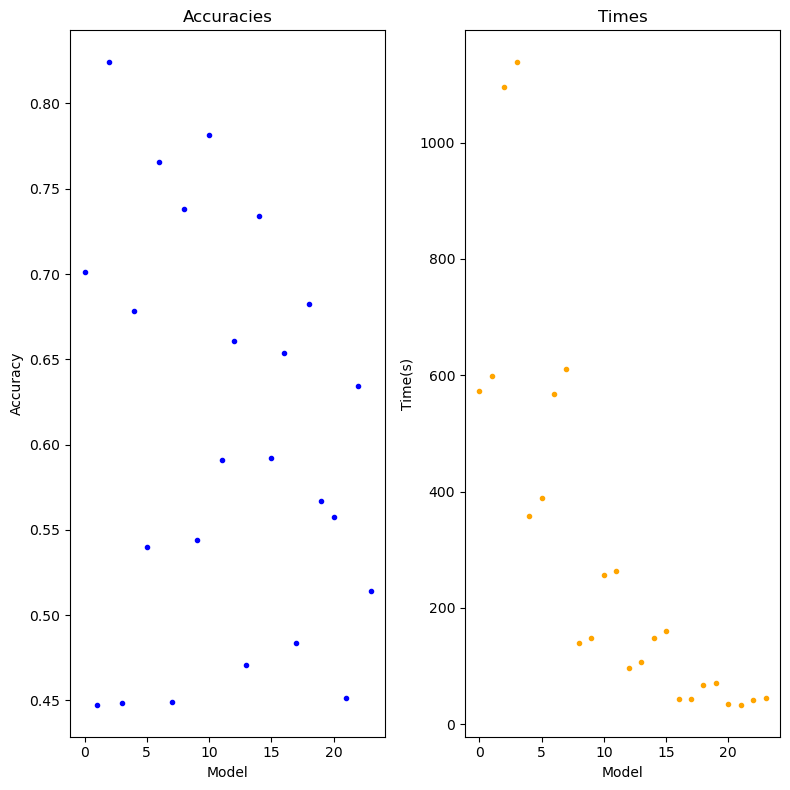

In [24]:
## print the accuracies and times obtained
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,8))

ax1.scatter(list(range(0, len(tams_L)*len(modelsTams[0]))), [x for sublist in accuracies for x in sublist], color='blue', marker='.')
ax1.set_title('Accuracies')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')

ax2.scatter(list(range(0, len(tams_L)*len(modelsTams[0]))), [x for sublist in times for x in sublist], color='orange', marker='.')
ax2.set_title('Times')
ax2.set_xlabel('Model')
ax2.set_ylabel('Time(s)')

plt.tight_layout()
plt.show()

## Evaluate the models

In [25]:
acc = 0
for i in range(0, len(tams_L)):
    for j in range (0, len(modelsTams[i])):
        print("Model ", i, j);
        score = modelsTams[i][j].evaluate(train_test_conditioned[i][1], train_test_conditioned[i][3], verbose=0)
        print("Test accuracy: ", score[1])
        if(score[1] > acc):
            acc = score[1]
            best_i = i
            best_j = j
print("Best model ", best_i, best_j)

Model  0 0
Test accuracy:  0.6418581604957581
Model  0 1
Test accuracy:  0.44955044984817505
Model  0 2
Test accuracy:  0.6698301434516907
Model  0 3
Test accuracy:  0.44955044984817505
Model  0 4
Test accuracy:  0.6623376607894897
Model  0 5
Test accuracy:  0.5494505763053894
Model  0 6
Test accuracy:  0.7220279574394226
Model  0 7
Test accuracy:  0.44955044984817505
Model  1 0
Test accuracy:  0.6970529556274414
Model  1 1
Test accuracy:  0.5509490370750427
Model  1 2
Test accuracy:  0.703046977519989
Model  1 3
Test accuracy:  0.5991508364677429
Model  1 4
Test accuracy:  0.6830669045448303
Model  1 5
Test accuracy:  0.49000999331474304
Model  1 6
Test accuracy:  0.730269730091095
Model  1 7
Test accuracy:  0.6138861179351807
Model  2 0
Test accuracy:  0.6625874042510986
Model  2 1
Test accuracy:  0.4872627258300781
Model  2 2
Test accuracy:  0.6615884304046631
Model  2 3
Test accuracy:  0.5639360547065735
Model  2 4
Test accuracy:  0.5814185738563538
Model  2 5
Test accuracy:  0.440

In [26]:
# Visualize the summary of the best model
activation_function = modelsTams[best_i][best_j].layers[1].activation
kernel_size = modelsTams[best_i][best_j].layers[1].kernel_size
pool_size = modelsTams[best_i][best_j].layers[2].pool_size

print("Input size:", tams_L[best_i])
print("Activation function: ", activation_function)
print("Kernel size: ", kernel_size)
print("Pool size: ", pool_size)

Input size: (48, 48)
Activation function:  <function relu at 0x00000229782A6AC0>
Kernel size:  (6, 6)
Pool size:  (3, 3)


## Save the best model

In [27]:
model_pkl_file = "./CNN_classifier_fer3.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(modelsTams[best_i][best_j], file)

## Visualize the confusion matrix of each model

In [28]:
#process the real classes for the confusion matrix
y_real = list()
for i in range(0, len(tams_L)):
    instances = train_test_conditioned[i][3]
    y_instance = list()
    for k in range (0, len(instances)):
        y_instance.append(decode(instances[k]))
    y_real.append(y_instance)

model:  0 0


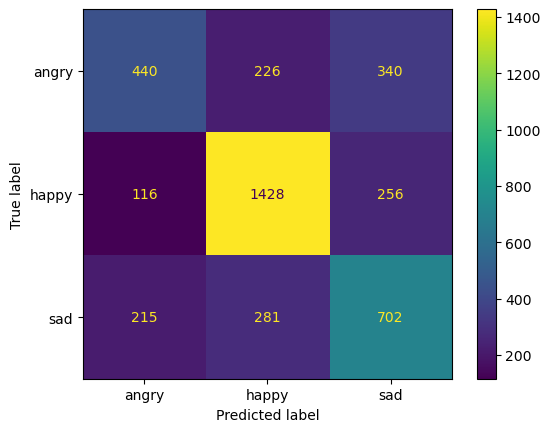

model:  0 1


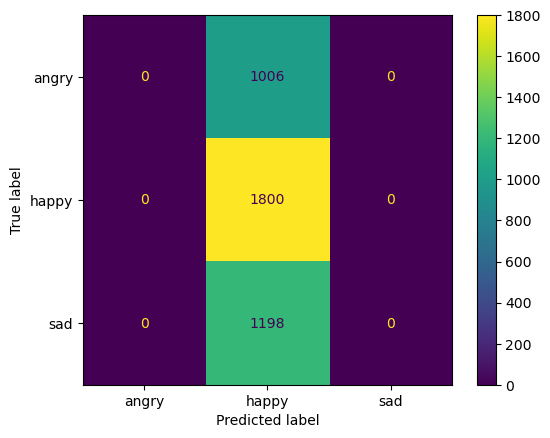

model:  0 2


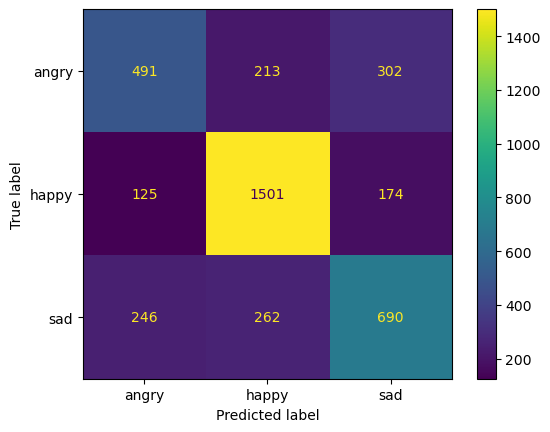

model:  0 3


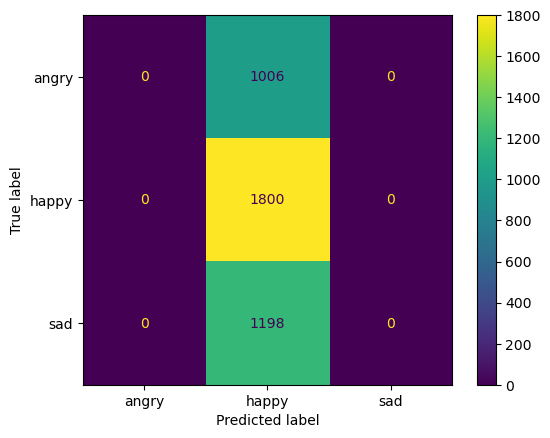

model:  0 4


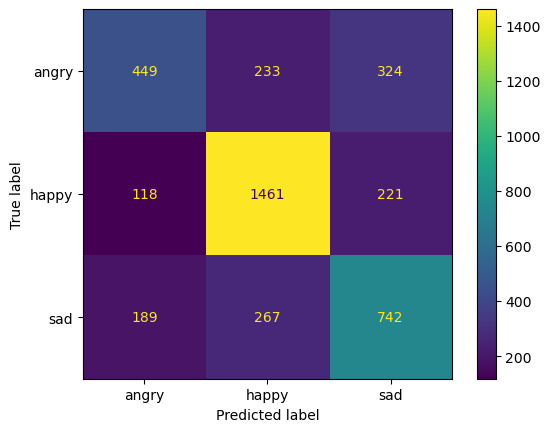

model:  0 5


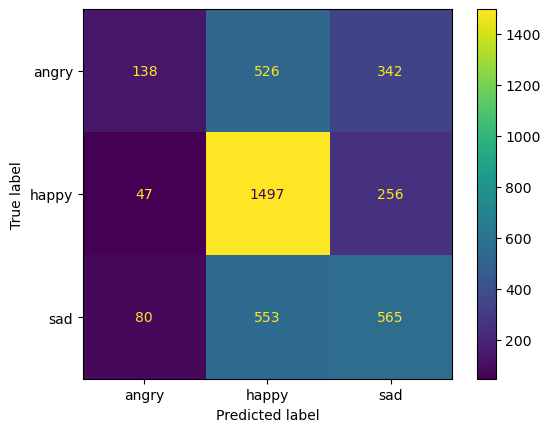

model:  0 6


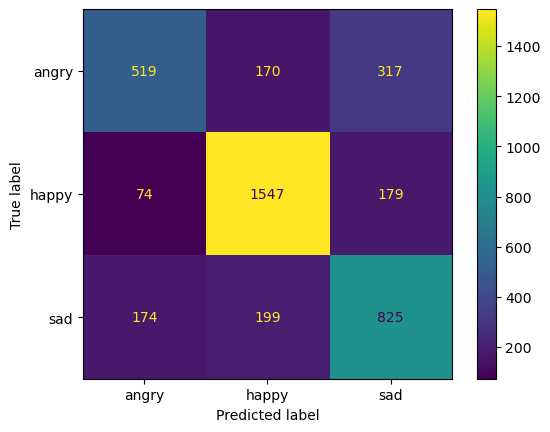

model:  0 7


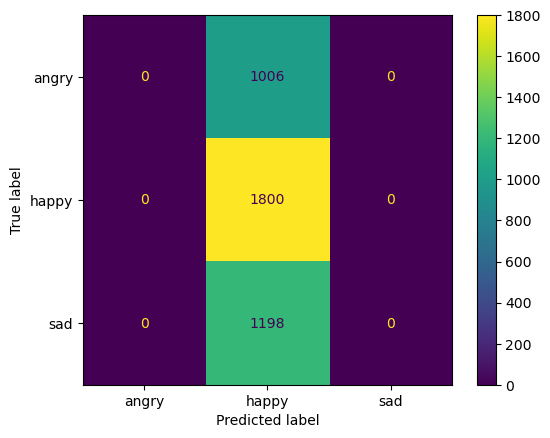

model:  1 0


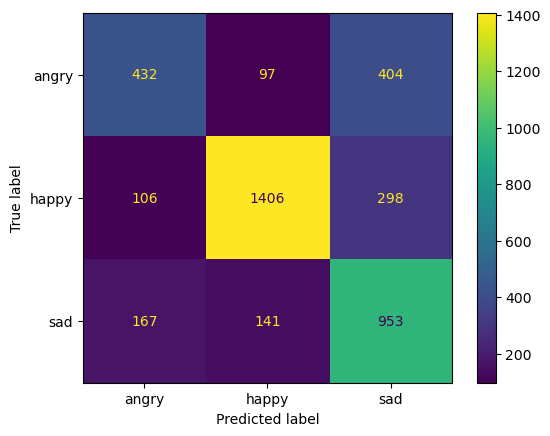

model:  1 1


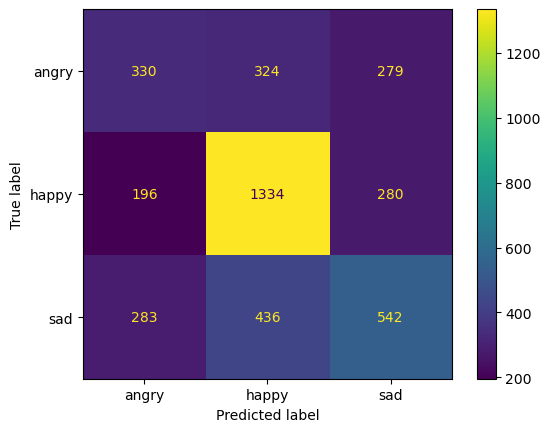

model:  1 2


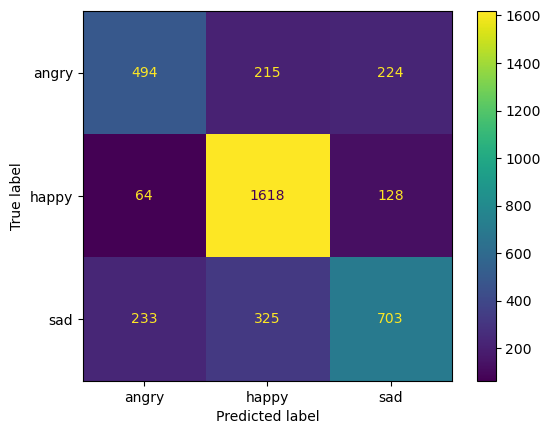

model:  1 3


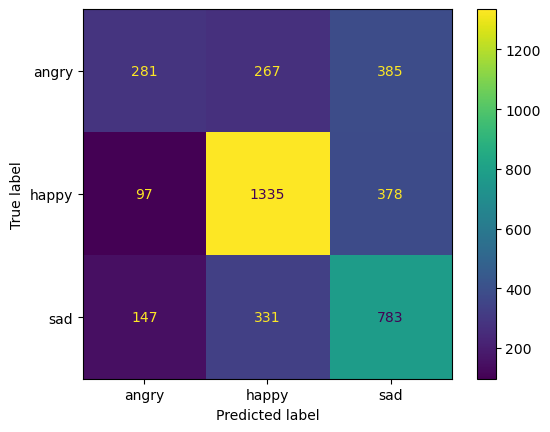

model:  1 4


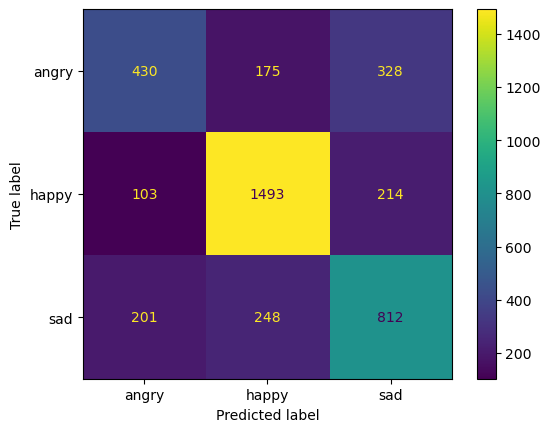

model:  1 5


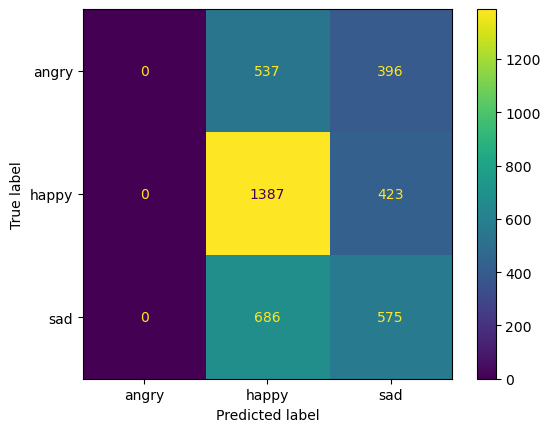

model:  1 6


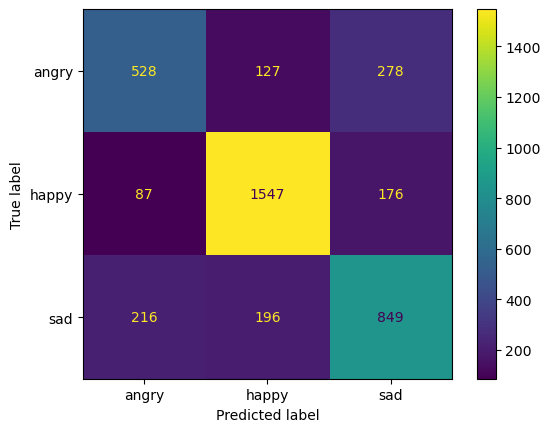

model:  1 7


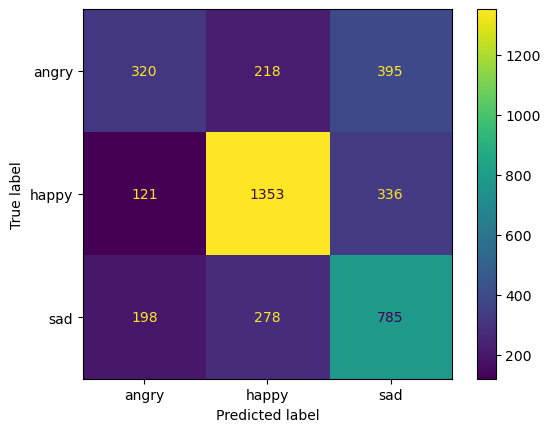

model:  2 0


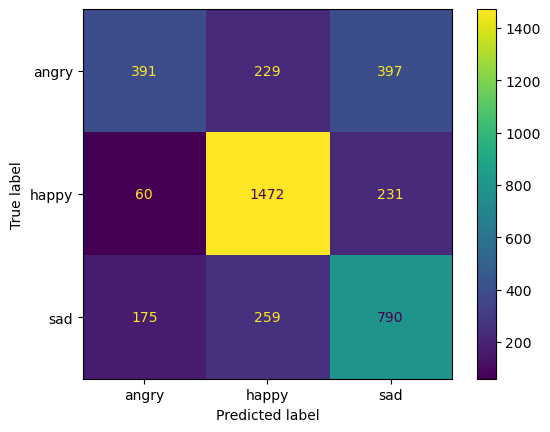

model:  2 1


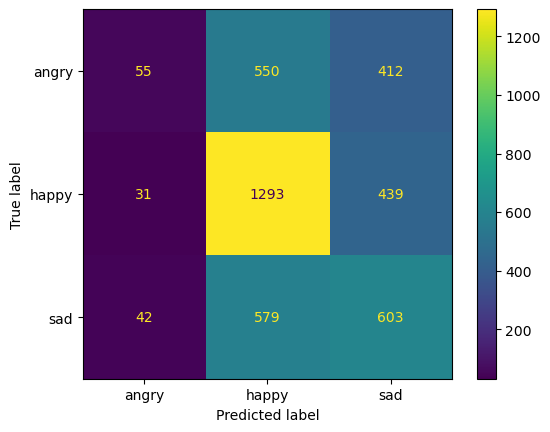

model:  2 2


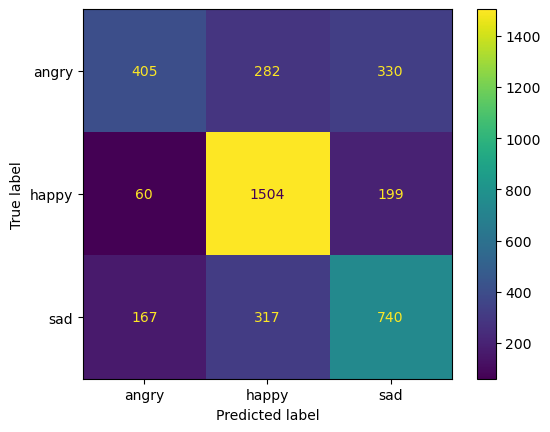

model:  2 3


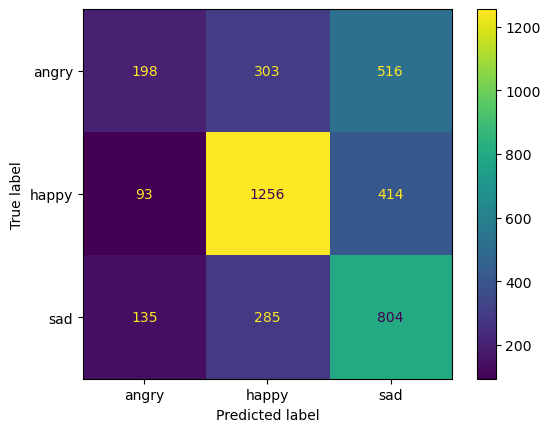

model:  2 4


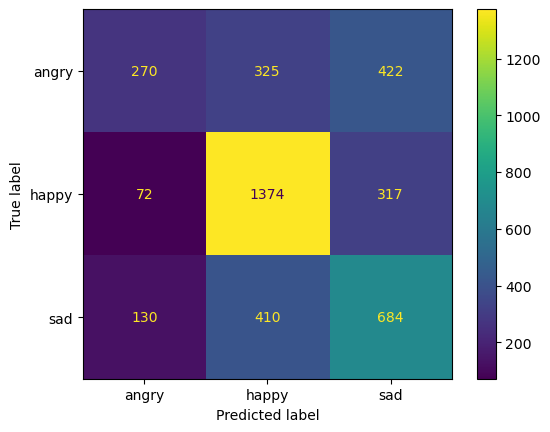

model:  2 5


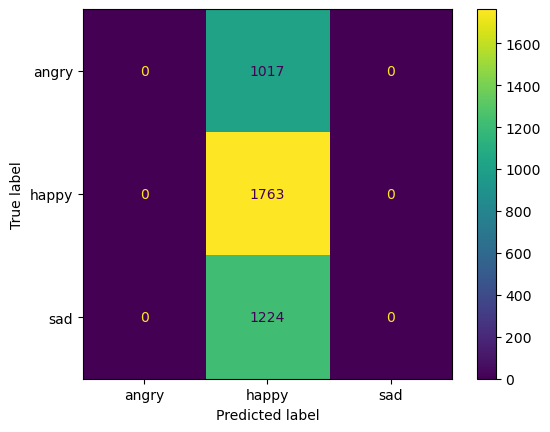

model:  2 6


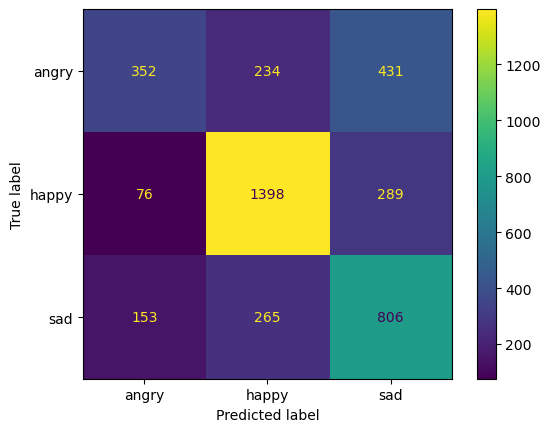

model:  2 7


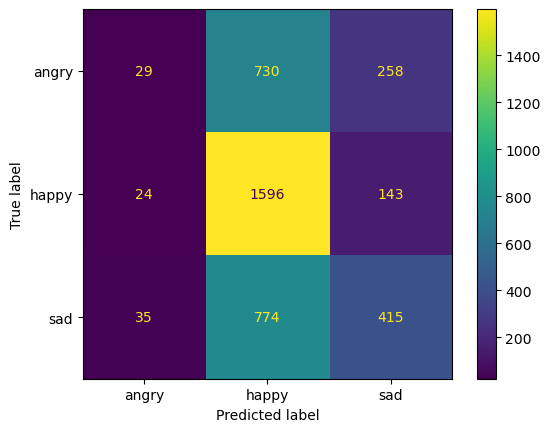

In [29]:
for i in range(0, len(tams_L)):
    #size of the data used
    l = list(tams_L[i]) #original size
    l[0], l[1] = l[1], l[0] #transpose
    l.append(1)
    l = (1,) + tuple(l)
    instances = train_test_conditioned[i][1] #test data
    for j in range (0, len(modelsTams[i])):
        predictions_j = list()
        for k in range (0, len(instances)):
            predictions_j.append(numeric_to_class(modelsTams[i][j](instances[k].reshape(l)).numpy().argmax(axis=1)[0]))
        print("model: ", i, j)
        #confusion matrix
        cm = confusion_matrix(y_real[i], predictions_j, labels=['angry', 'happy','sad'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'happy','sad'])
        disp.plot()
        plt.show()